In [1]:
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from os.path import join
import os
import cmocean.cm as cm
import cartopy.crs as ccrs
from datetime import datetime, timedelta, date
import xarray as xr
import sys
sys.path.append("../")
from proc_utils.gom import lc_from_ssh

# Define dates and domain

In [2]:
root_folder = "/Net/work/ozavala/GOFFISH/"

sss_path = "SSS/SMAP_Global"
adt_path = "AVISO"
sst_path = "SST/OISST"
chlora_path = "CHLORA/NOAA"

start_date = datetime.strptime("2020-01-01", "%Y-%m-%d")
end_date = datetime.strptime("2021-01-01", "%Y-%m-%d")
cur_date = start_date

bbox = (-99, -74, 17, 31)
# bbox= (-91, -80, 20, 28)
lon = (bbox[0], bbox[1])
lon_360 = (360 + bbox[0], 360 + bbox[1])
lat = (bbox[2], bbox[3])

# Read and crop data function

In [4]:
# ------------------------ For speed testing ----------------
def read_day(cur_date):
    year = cur_date.year
    month = cur_date.month
    day_year = cur_date.timetuple().tm_yday
    day_month = cur_date.day
    
    sss_file = join(root_folder, sss_path, str(year), f"RSS_smap_SSS_L3_8day_running_{year}_{day_year:03d}_FNL_v05.0.nc")
    adt_file = join(root_folder, adt_path, f"{year}-{month:02d}.nc")
    sst_file = join(root_folder, sst_path, str(year), f"{year}{month:02d}{day_month:02d}090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1_subset.nc")
    chlora_file = join(root_folder, chlora_path, f"{year}-{month:02d}-{day_month:02d}.nc")

    assert os.path.exists(sss_file)
    assert os.path.exists(adt_file)
    assert os.path.exists(sst_file)
    assert os.path.exists(chlora_file)

    # Reading data
    print("Reading...", flush=True)
    sss_orig = xr.load_dataset(sss_file)
    adt_orig = xr.load_dataset(adt_file)
    sst_orig = xr.load_dataset(sst_file)
    chlora_orig = xr.load_dataset(chlora_file)

    # Cropping to the same domain
    print("Cropping...", flush=True)
    adt = adt_orig.sel(latitude=slice(lat[0], lat[1]), longitude=slice(lon[0], lon[1]))
    sss = sss_orig.sel(lat=slice(lat[0], lat[1]), lon=slice(lon_360[0], lon_360[1]))
    sst = sst_orig.sel(lat=slice(lat[0], lat[1]), lon=slice(lon[0], lon[1]))
    chlora = chlora_orig.sel(latitude=slice(lat[1], lat[0]), longitude=slice(lon[0], lon[1]))  # For some reason latitude is flipped
    
    sss_orig.close()
    adt_orig.close()
    sst_orig.close()
    chlora_orig.close()
    
    adt_slice = adt.adt[day_month,:,:]
    sss_slice = sss.sss_smap_40km[:,:]
    sst_slice = sst.analysed_sst[0,:,:]
    chlora_slice = chlora.chlor_a[0,0,:,:]
    
    # Computing LC
    print("Computing LC...", flush=True)
    lats_adt = adt.latitude
    lons_adt = adt.longitude
    lc = lc_from_ssh(adt_slice.values, lons_adt, lats_adt)
    
    return adt_slice, sss_slice, sst_slice, chlora_slice, LineString(list(lc))

# Plot function

In [5]:
def plotData(fig, axs, adt, sss, sst, chlora, lc):
    
    print("Plotting...", flush=True) 
    # Plot each slice
    im_adt = axs[0][0].imshow(adt, origin='lower', cmap=cm.balance, extent=bbox, transform=ccrs.PlateCarree())
    im_sss = axs[0][1].imshow(sss, origin='lower', cmap=cm.haline, norm=LogNorm(vmin=30, vmax=38), extent=bbox, transform=ccrs.PlateCarree())
    im_sst = axs[1][0].imshow(sst, origin='lower', cmap=cm.thermal,  extent=bbox, transform=ccrs.PlateCarree())
    im_chlor_a = axs[1][1].imshow(chlora, origin='upper', cmap=cm.algae, norm=LogNorm(vmin=.15, vmax=.3), extent=bbox, transform=ccrs.PlateCarree())
    
    # Add LC
    for c_polygon in lc:
        x, y = c_polygon.xy
        
#     axs[0][0].scatter(x, y, transform=self._projection, c='r')
#     axs[0][1].scatter(x, y, transform=self._projection, c='r')
#     axs[1][0].scatter(x, y, transform=self._projection, c='r')
#     axs[1][1].scatter(x, y, transform=self._projection, c='r')

    # Set titles
    axs[0][0].set_title("ADT")
    axs[0][1].set_title("SSS")
    axs[1][0].set_title("SST")
    axs[1][1].set_title("CHLORA ")

    # Assign gridlines
    for ax in fig.get_axes():
        gl = ax.gridlines(draw_labels=True, color='grey', alpha=0.5, linestyle='--')
        gl.top_labels = False
        gl.left_labels = False

    # Add colorbars 
    shrink = 0.7
    fig.colorbar(im_adt, ax=axs[0][0], shrink=shrink)
    fig.colorbar(im_sss, ax=axs[0][1], shrink=shrink)
    fig.colorbar(im_sst, ax=axs[1][0], shrink=shrink)
    fig.colorbar(im_chlor_a, ax=axs[1][1], shrink=shrink)

    plt.suptitle(cur_date)
    plt.tight_layout(pad=1.5)
    
    return fig

# Save plots as images

Reading...


ValueError: found the following matches with the input file in xarray's IO backends: ['netcdf4', 'h5netcdf']. But their dependencies may not be installed, see:
https://docs.xarray.dev/en/stable/user-guide/io.html 
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html

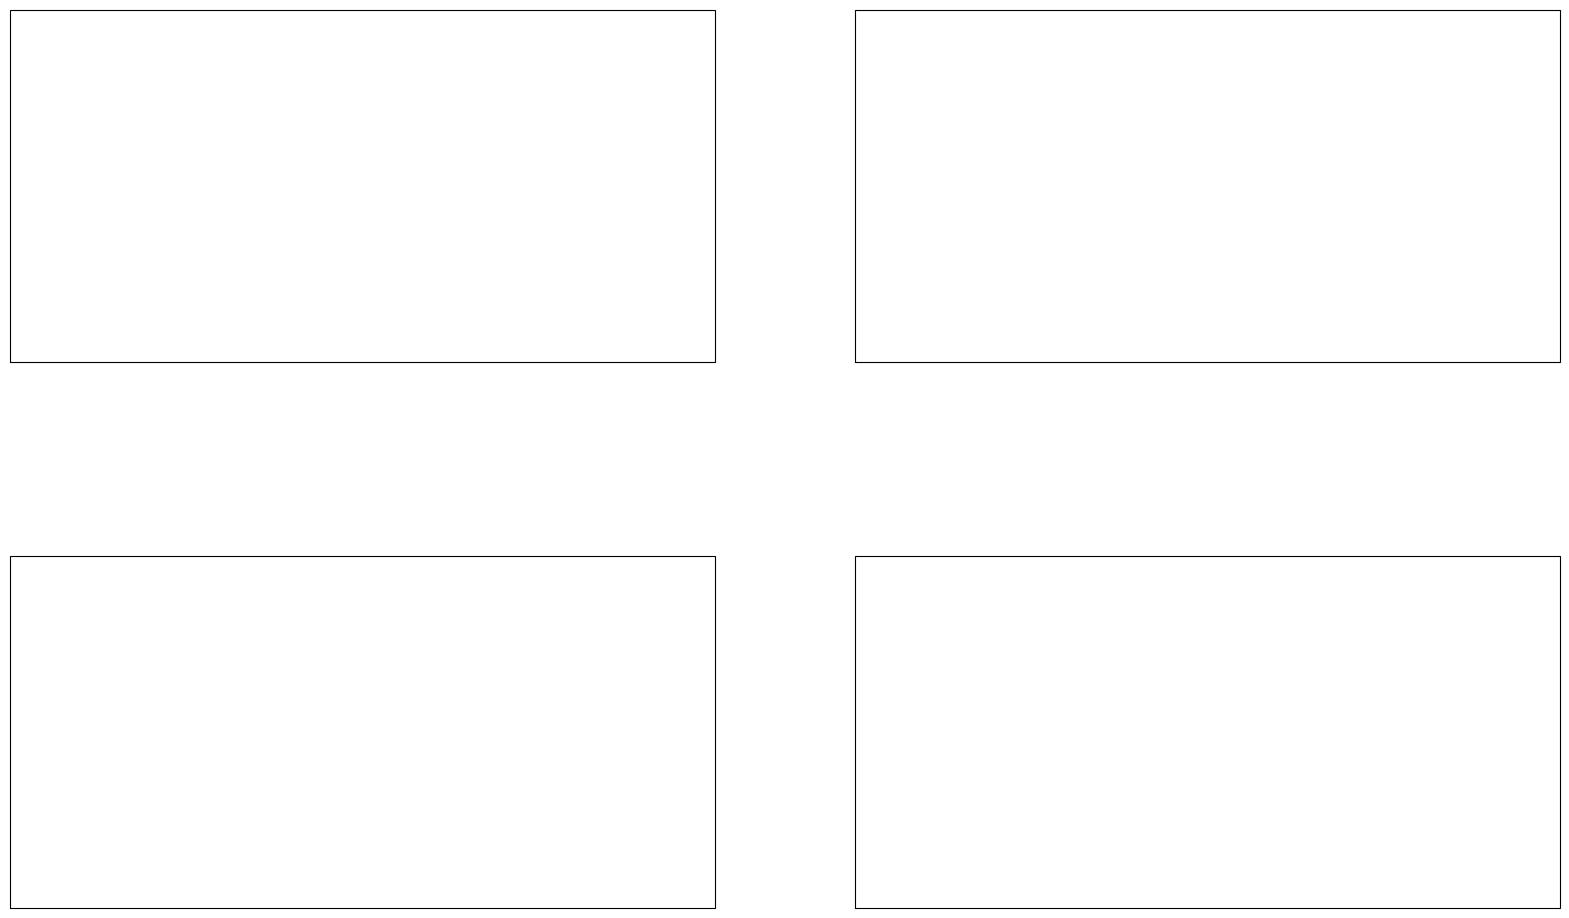

In [6]:

# Make a video of 2019 to 2021
start_date = date(2019,1,1)
end_date = date(2019,1,3)

cur_date = start_date
while cur_date < end_date:
    fig, axs = plt.subplots(2, 2, figsize=(20, 13), subplot_kw={'projection': ccrs.PlateCarree()})
    file_name = join("/Net/work/ozavala/GOFFISH/imgs/SatelliteDataComparison", cur_date.strftime("%Y-%m-%d"))
    adt, sss, sst, chlora, lc = read_day(cur_date)
    fig = plotData(fig, axs, adt, sss, sst, chlora, lc)
    plt.show()
    # plt.savefig(file_name)
    # print(f"Done saving {cur_date}", flush=True)
    cur_date += timedelta(days=1)
    plt.close()
    exit()
    

In [ ]:
@interact(cur_date=widgets.DatePicker(description='Pick a Date', disabled=False, value=date(2019,1,1)))
def plotDay(cur_date):
    adt, sss, sst, chlora = read_day(cur_date)
    plotData(adt, sss, sst, chlora)